In [4]:
# =========================
# Setup & Tải dữ liệu
# =========================
# - Tải Face Mask Dataset từ Kaggle bằng kagglehub
# - Khai báo các đường dẫn và cấu hình cơ bản

import os
import random
import numpy as np
import tensorflow as tf
import kagglehub

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

DATASET = "ashishjangra27/face-mask-12k-images-dataset"
path = kagglehub.dataset_download(DATASET)
print("Path to dataset files:", path)

# Đường dẫn train/val/test
dataset_path = os.path.join(path, "Face Mask Dataset")
train_dir = os.path.join(dataset_path, "Train")
val_dir   = os.path.join(dataset_path, "Validation")
test_dir  = os.path.join(dataset_path, "Test")

for d in [train_dir, val_dir, test_dir]:
    if not os.path.isdir(d):
        raise FileNotFoundError(f"Không tìm thấy thư mục: {d}")
print("Đã sẵn sàng: Train/Validation/Test")

# Cấu hình
IMG_SIZE   = (224, 224)  # EfficientNetB0
BATCH_SIZE = 32
NUM_CLASSES = 2
MODEL_NAME  = "EfficientNetB0"

print(f"Cấu hình — IMG_SIZE: {IMG_SIZE}, BATCH_SIZE: {BATCH_SIZE}, NUM_CLASSES: {NUM_CLASSES}, MODEL: {MODEL_NAME}")


Path to dataset files: /root/.cache/kagglehub/datasets/ashishjangra27/face-mask-12k-images-dataset/versions/1
Đã sẵn sàng: Train/Validation/Test
Cấu hình — IMG_SIZE: (224, 224), BATCH_SIZE: 32, NUM_CLASSES: 2, MODEL: EfficientNetB0


In [5]:
# =========================
# Dataloader & Prefetch
# =========================
# Mục tiêu:
# - Tạo tf.data cho Train/Val/Test từ thư mục
# - Cache + prefetch để tăng throughput
# - Shuffle cho train

from tensorflow.keras.preprocessing import image_dataset_from_directory

AUTOTUNE = tf.data.AUTOTUNE

train_raw = image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True,
    label_mode="int",
)

val_raw = image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    label_mode="int",
)

test_raw = image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    label_mode="int",
)

class_names = train_raw.class_names
print("class_names:", class_names)

# cache + prefetch
train_ds = train_raw.cache().prefetch(AUTOTUNE)
val_ds   = val_raw.cache().prefetch(AUTOTUNE)
test_ds  = test_raw.cache().prefetch(AUTOTUNE)

# In số mẫu để kiểm tra nhanh
n_train = train_raw.cardinality().numpy() * BATCH_SIZE
n_val   = val_raw.cardinality().numpy()   * BATCH_SIZE
n_test  = test_raw.cardinality().numpy()  * BATCH_SIZE
print(f"Samples — train≈{n_train}, val≈{n_val}, test≈{n_test}")

print("Data pipeline OK — augment & preprocess sẽ đặt trong model ở Cell 3")


Found 10000 files belonging to 2 classes.
Found 800 files belonging to 2 classes.
Found 992 files belonging to 2 classes.
class_names: ['WithMask', 'WithoutMask']
Samples — train≈10016, val≈800, test≈992
Data pipeline OK — augment & preprocess sẽ đặt trong model ở Cell 3


In [7]:
# =========================
# Cell 3 — Augmentation layer (đặt trong model)
# =========================

from tensorflow.keras import layers, Sequential

data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),     # ~±5%
        layers.RandomZoom(0.10),         # phóng/thu nhẹ
        layers.RandomContrast(0.10),     # thay đổi độ tương phản
        layers.RandomTranslation(0.05, 0.05),  # dịch chuyển nhẹ
    ],
    name="augmentation"
)

print("Augmentation layer sẵn sàng")


Augmentation layer sẵn sàng


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.applications import EfficientNetB0

# Input
inputs = layers.Input(shape=IMG_SIZE + (3,), name="image")

# Augmentation
x = data_augmentation(inputs)

# Backbone EfficientNetB0 (ImageNet weights)
base = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=x)
base.trainable = False  # Phase 1: train head

# Head
x = layers.GlobalAveragePooling2D(name="gap")(base.output)
x = layers.Dropout(0.3, name="dropout")(x)
outputs = layers.Dense(1, activation="sigmoid", dtype="float32", name="pred")(x)

model = models.Model(inputs, outputs, name=f"{MODEL_NAME}-binary")

# Optimizer + compile
optimizer = AdamW(learning_rate=1e-3, weight_decay=1e-5, global_clipnorm=1.0)
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name="acc"),
        tf.keras.metrics.AUC(name="auc", curve="ROC"),
    ],
)

print("Phase 1: Freeze backbone, train head")


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Phase 1: Freeze backbone, train head


In [9]:
import datetime as dt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

stamp = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
ckpt_path = f"checkpoints/{MODEL_NAME}_phase1_best_{stamp}.keras"

cbs = [
    EarlyStopping(monitor="val_auc", mode="max", patience=3, restore_best_weights=True),
    ModelCheckpoint(ckpt_path, monitor="val_auc", mode="max", save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-6),
]

EPOCHS_HEAD = 6  # 5–8
history_head = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_HEAD,
    callbacks=cbs,
)


Epoch 1/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - acc: 0.9683 - auc: 0.9932 - loss: 0.1471 - val_acc: 0.9925 - val_auc: 0.9999 - val_loss: 0.0175 - learning_rate: 0.0010
Epoch 2/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - acc: 0.9951 - auc: 0.9998 - loss: 0.0203 - val_acc: 0.9975 - val_auc: 1.0000 - val_loss: 0.0110 - learning_rate: 0.0010
Epoch 3/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - acc: 0.9969 - auc: 0.9999 - loss: 0.0138 - val_acc: 0.9975 - val_auc: 1.0000 - val_loss: 0.0085 - learning_rate: 0.0010
Epoch 4/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - acc: 0.9951 - auc: 0.9999 - loss: 0.0126 - val_acc: 0.9987 - val_auc: 1.0000 - val_loss: 0.0076 - learning_rate: 0.0010
Epoch 5/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - acc: 0.9978 - auc: 1.0000 - loss: 0.0092 - val_acc: 0.9987 - val_auc: 1.0000 - val_loss: 0.0071 - learning_rate: 0.0010
Epoch 6/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - acc: 0.9980 - auc: 1.0000 - loss: 0.0081 - val_acc: 0.9987 - val_auc:

In [10]:
# unfreeze các block cuối để ổn định hơn
set_trainable = False
for layer in base.layers:
    name = layer.name
    if name.startswith("block6") or name.startswith("block7") or name in ("top_conv", "top_bn"):
        set_trainable = True
    # Không fine-tune BatchNorm để tránh lệch thống kê
    if set_trainable and not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

# số layer trainable:
trainable_count = np.sum([int(l.trainable) for l in model.layers])  # type: ignore
print("Trainable layers:", trainable_count)

# Re-compile với LR nhỏ hơn nhiều
optimizer_ft = AdamW(learning_rate=1e-5, weight_decay=1e-5, global_clipnorm=1.0)
model.compile(
    optimizer=optimizer_ft,
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.BinaryAccuracy(name="acc"),
             tf.keras.metrics.AUC(name="auc", curve="ROC")],
)

ckpt_path_ft = f"checkpoints/{MODEL_NAME}_finetune_best_{stamp}.keras"
cbs_ft = [
    EarlyStopping(monitor="val_auc", mode="max", patience=3, restore_best_weights=True),
    ModelCheckpoint(ckpt_path_ft, monitor="val_auc", mode="max", save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-7),
]

EPOCHS_FT = 8  # 6–12
history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FT,
    callbacks=cbs_ft,
)


Trainable layers: 62
Epoch 1/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 52s 115ms/step - acc: 0.9989 - auc: 1.0000 - loss: 0.0053 - val_acc: 0.9987 - val_auc: 1.0000 - val_loss: 0.0026 - learning_rate: 1.0000e-05
Epoch 2/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 108ms/step - acc: 0.9986 - auc: 1.0000 - loss: 0.0040 - val_acc: 0.9987 - val_auc: 1.0000 - val_loss: 0.0014 - learning_rate: 1.0000e-05
Epoch 3/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 102ms/step - acc: 0.9988 - auc: 0.9999 - loss: 0.0028 - val_acc: 1.0000 - val_auc: 1.0000 - val_loss: 6.5643e-04 - learning_rate: 1.0000e-05
Epoch 4/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 103ms/step - acc: 0.9990 - auc: 1.0000 - loss: 0.0023 - val_acc: 1.0000 - val_auc: 1.0000 - val_loss: 3.0832e-04 - learning_rate: 1.0000e-05
Epoch 5/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 102ms/step - acc: 0.9995 - auc: 0.9999 - loss: 0.0023 - val_acc: 1.0000 - val_auc: 1.0000 - val_loss: 1.5151e-04 - learning_rate: 1.0000e-05


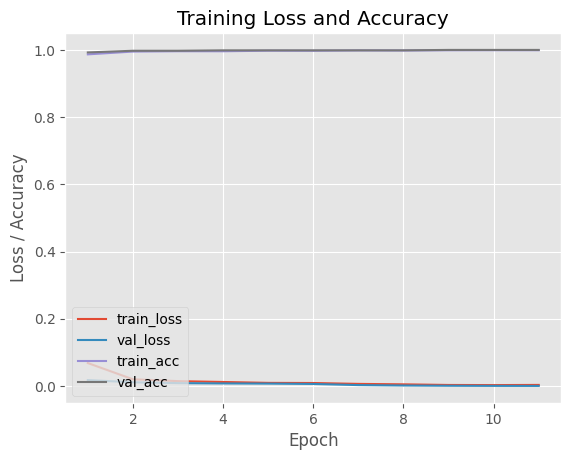

In [12]:
# =========================
# TRAINING CURVE (Loss & Accuracy)
# =========================
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("ggplot")

# Gom các history có thể tồn tại: H (theo mẫu), history, history_head, history_ft
histories = []
for name in ["H", "history", "history_head", "history_ft"]:
    if name in globals() and hasattr(globals()[name], "history"):
        histories.append(globals()[name].history)

# Nếu chưa có gì thì báo để kiểm tra lại tên biến
if not histories:
    raise RuntimeError(
        "Không tìm thấy biến history nào (H/history/history_head/history_ft). "
        "Hãy đảm bảo bạn gán kết quả model.fit(...) vào 1 trong các biến này."
    )

# Gộp các chỉ số
losses, val_losses, accs, val_accs = [], [], [], []
for h in histories:
    losses.extend(h.get("loss", []))
    val_losses.extend(h.get("val_loss", []))
    accs.extend(h.get("acc", h.get("accuracy", [])))
    val_accs.extend(h.get("val_acc", h.get("val_accuracy", [])))

N = len(losses)
x = np.arange(1, N + 1)

plt.figure()
plt.plot(x, losses, label="train_loss")
plt.plot(x, val_losses, label="val_loss")
plt.plot(x, accs, label="train_acc")
plt.plot(x, val_accs, label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.legend(loc="lower left")
plt.show()


              precision    recall  f1-score   support

    WithMask       1.00      1.00      1.00       483
 WithoutMask       1.00      1.00      1.00       509

    accuracy                           1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg       1.00      1.00      1.00       992



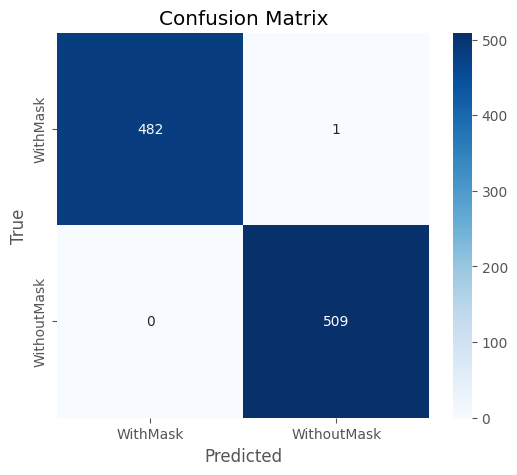

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - acc: 0.9960 - auc: 0.5307 - loss: 0.0293
Loss: 0.0087
Độ chính xác trên tập test: 99.90%
AUC: 0.9990


In [13]:
# =============================
# ĐÁNH GIÁ TRÊN TẬP TEST
# =============================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Dự đoán xác suất trên test set
probs = model.predict(test_ds, verbose=0).ravel()   # (N,)
y_pred = (probs >= 0.5).astype(int)                 # sigmoid nhãn 0/1

# Lấy nhãn thật
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Đặt tên lớp
class_labels = list(test_ds.class_names) if hasattr(test_ds, "class_names") else ["WithMask","WithoutMask"]

# In classification report
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Đánh giá trực tiếp với model.evaluate trên tập test
res = model.evaluate(test_ds, verbose=1, return_dict=True)
print(f"Loss: {res['loss']:.4f}")
acc_key = next((k for k in res.keys() if 'acc' in k), None)
if acc_key:
    print(f"Độ chính xác trên tập test: {res[acc_key]*100:.2f}%")
if 'auc' in res:
    print(f"AUC: {res['auc']:.4f}")


In [14]:
model.save('model2.keras')